## **Enabling GPU within our notebook**

### Cloning and Building Darknet for setting up 

In [1]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15214, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 15214 (delta 15), reused 19 (delta 12), pack-reused 15185
Receiving objects: 100% (15214/15214), 13.65 MiB | 23.37 MiB/s, done.
Resolving deltas: 100% (10325/10325), done.


In [2]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


In [3]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [4]:
# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
  

## **Define Helper Functions**

These three functions are helper functions that will allow you to show the image in your Colab Notebook after running your detections, as well as upload and download images to and from your Cloud VM

In [20]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

## **Uploading google drive files**

In [5]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/content
Mounted at /content/gdrive


In [6]:
# cd back into the darknet folder to run detections
%cd /content/darknet

/content/darknet


# **Upload yolov4apple folder to google drive** 

In [7]:
# this is where my datasets are stored within my Google Drive (I created a yolov4apple folder to store all important files for custom training) 
!ls /content/gdrive/MyDrive/yolov4apple

backup		  generate_train.py  obj.names	test.zip
generate_test.py  obj.data	     obj.zip	yolov4-obj.cfg


#### **Copy the "obj.zip" & "test.zip" to colab**

Open yolov4apple folder and copy the path of obj.zip and test.zip 

In [8]:
# copy over both datasets into the root directory of the Colab VM 
!cp /content/gdrive/MyDrive/yolov4apple/obj.zip ../
!cp /content/gdrive/MyDrive/yolov4apple/test.zip ../

In [9]:
# unzip the datasets and their contents so that they are now in /darknet/data/ folder
!unzip ../obj.zip -d data/
!unzip ../test.zip -d data/

Archive:  ../obj.zip
  inflating: data/obj/apple_1_png.rf.54b484ad8da9682da3d8e8d9598cd77e.jpg  
  inflating: data/obj/apple_1_png.rf.54b484ad8da9682da3d8e8d9598cd77e.txt  
  inflating: data/obj/apple_1_png.rf.a5b2a17e826a44bda838280b5cb7619d.jpg  
  inflating: data/obj/apple_1_png.rf.a5b2a17e826a44bda838280b5cb7619d.txt  
  inflating: data/obj/apple_1_png.rf.cbd267db7d4b6de32b08f0b3ade341f0.jpg  
  inflating: data/obj/apple_1_png.rf.cbd267db7d4b6de32b08f0b3ade341f0.txt  
  inflating: data/obj/apple_2_png.rf.4097db13ee24e586942c399a425443d5.jpg  
  inflating: data/obj/apple_2_png.rf.4097db13ee24e586942c399a425443d5.txt  
  inflating: data/obj/apple_2_png.rf.8d189cac0aa0a1f8bf679b1d9085590a.jpg  
  inflating: data/obj/apple_2_png.rf.8d189cac0aa0a1f8bf679b1d9085590a.txt  
  inflating: data/obj/apple_2_png.rf.9acaa8a84437d4b1d54fb24b5c3fc5df.jpg  
  inflating: data/obj/apple_2_png.rf.9acaa8a84437d4b1d54fb24b5c3fc5df.txt  
  inflating: data/obj/apple_3_png.rf.36020ae54c35edb146cb72fb6a3021

## **obj.names & obj.data**

Open yolov4apple and copy the path of obj.names and obj.data

In [10]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp /content/gdrive/MyDrive/yolov4apple/obj.names ./data
!cp /content/gdrive/MyDrive/yolov4apple/obj.data ./data

## **Generating train.txt and test.txt**
The last configuration files needed before we can begin to train our custom detector are the train.txt and test.txt files which hold the relative paths to all our training images and valdidation images.

**open yolov4apple folder and copy the paths of generate_train.py and generate_test_py**

In [11]:
# upload the generate_train.py and generate_test.py script to cloud VM from Google Drive
!cp /content/gdrive/MyDrive/yolov4apple/generate_train.py ./
!cp /content/gdrive/MyDrive/yolov4apple/generate_test.py ./

In [12]:
!python generate_train.py
!python generate_test.py

In [13]:
# verify that the newly generated train.txt and test.txt can be seen in our darknet/data folder
!ls data/

9k.tree     giraffe.jpg		      labels		person.jpg  voc.names
coco9k.map  goal.txt		      obj		scream.jpg
coco.names  horses.jpg		      obj.data		test
dog.jpg     imagenet.labels.list      obj.names		test.txt
eagle.jpg   imagenet.shortnames.list  openimages.names	train.txt


## **Configuring Files for Training**
This step involves properly configuring your custom .cfg, obj.data, obj.names, train.txt and test.txt files.

It is important to configure all these files with extreme caution as typos or small errors can cause major problems with your custom training.

have chage the custom configuration according to my use like I have change the classes from 80 to 1 and the filter sizes are 18 throughout.
The dimension of the image will be 416 by 416.

**open yolov4apple folder and copy path of yolov4-obj.cfg**

In [16]:
# upload the custom .cfg back to cloud VM from Google Drive
!cp /content/gdrive/MyDrive/yolov4apple/yolov4-obj.cfg ./cfg

In [17]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-obj.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-obj.cfg
%cd ..

/content/darknet/cfg
/content/darknet


# **Upload a image from your device** 

In [24]:
# try out the upload helper function! 
%cd ..
upload()
%cd /content/darknet

/content


Saving apple.jpg to apple.jpg
saved file apple.jpg
/content/darknet


# **Run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)**

Please follow the path of obj.data(/content/darknet/data/obj.data), yolov4-obj.cfg (/content/darknet/cfg/yolov4-obj.cfg) and the trained weights after 2000 batches which is store in "backup" folder under "yolov4apple" (/content/gdrive/MyDrive/yolov4apple/backup/yolov4-obj_2000.weights)

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv   

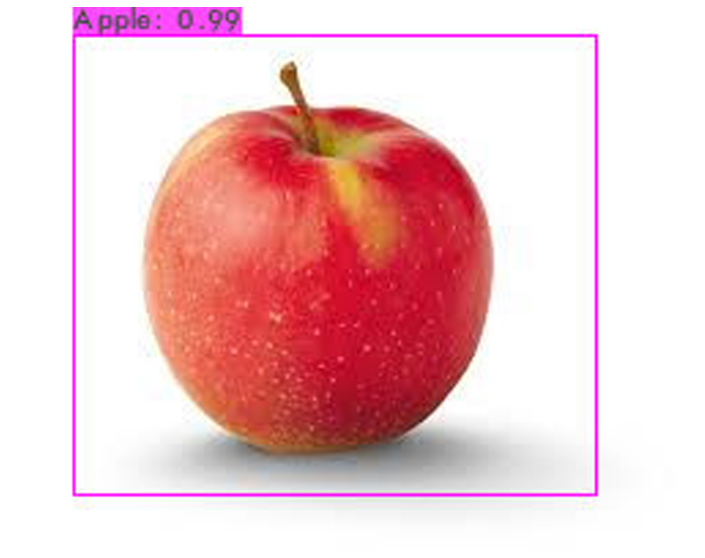

In [25]:
!./darknet detector test  /content/darknet/data/obj.data /content/darknet/cfg/yolov4-obj.cfg /content/gdrive/MyDrive/yolov4apple/backup/yolov4-obj_2000.weights ../apple.jpg -thresh 0.4
imShow('predictions.jpg')